In [5]:
import pandas as pd
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
from numpy import array

In [110]:
# date-time parsing function for loading the dataset
def parser(x):
	return datetime.strptime('190'+x, '%Y-%m')

# convert time series into supervised learning problem
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# transform series into train and test sets for supervised learning
def prepare_data(series, n_test, n_lag, n_seq):
	# extract raw values
	raw_values = series#.values
	# transform data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	# rescale values to -1, 1
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	# transform into supervised learning problem X, y
	supervised = series_to_supervised(scaled_values, n_lag, n_seq)
	supervised_values = supervised.values
	# split into train and test sets
	train, test = supervised_values[0:-n_test], supervised_values[-n_test:]
	return scaler, train, test

# fit an LSTM network to training data
def fit_lstm(train, n_lag, n_seq, n_batch, nb_epoch, n_neurons):
	# reshape training into [samples, timesteps, features]
	X, y = train[:, 0:n_lag], train[:, n_lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# design network
	model = Sequential()
	model.add(LSTM(n_neurons, batch_input_shape=(n_batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit network
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=n_batch, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make one forecast with an LSTM,
def forecast_lstm(model, X, n_batch):
	# reshape input pattern to [samples, timesteps, features]
	X = X.reshape(1, 1, len(X))
	# make forecast
	forecast = model.predict(X, batch_size=n_batch)
	# convert to array
	return [x for x in forecast[0, :]]

# evaluate the persistence model
def make_forecasts(model, n_batch, train, test, n_lag, n_seq):
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:n_lag], test[i, n_lag:]
		# make forecast
		forecast = forecast_lstm(model, X, n_batch)
		# store the forecast
		forecasts.append(forecast)
	return forecasts

# invert differenced forecast
def inverse_difference(last_ob, forecast):
	# invert first forecast
	inverted = list()
	inverted.append(forecast[0] + last_ob)
	# propagate difference forecast using inverted first value
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, n_test):
	inverted = list()
	for i in range(len(forecasts)):
		# create array from forecast
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert scaling
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - n_test + i - 1
		last_ob = series[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, n_lag, n_seq):
	for i in range(n_seq):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	pyplot.figure(figsize=(15, 10))
    # plot the entire dataset in blue
	pyplot.plot(series)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		if i % 6 == 0:
			off_s = len(series) - n_test + i - 1
			off_e = off_s + len(forecasts[i]) + 1
			xaxis = [x for x in range(off_s, off_e)]
			yaxis = [series[off_s]] + forecasts[i]
			pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

In [92]:
def get_data_from_category(category, df):    
    dataset = df[df['company_category_list'] == category]
    dataset['year-month'] = dataset['announced_on'].str[:7]
    dataset = dataset.drop('announced_on', axis = 1)
    dataset.head()
    dataset = dataset.groupby('year-month').count().reset_index()
    MIN = dataset['year-month'].min()[:4]
    MAX = dataset['year-month'].max()[:4]

    for year in range(int(MIN), int(MAX)):
        for month in range(12):
            date = '{}-{:02d}'.format(year, month + 1)
            if dataset[dataset['year-month'] == date].shape[0] == 0:
                dataset.loc[dataset.shape[0]] = [date, 0]

    dataset = dataset.sort_values('year-month')            
    dataset = dataset[:-1]['company_category_list'].values
    return dataset

In [76]:
# load data
df_funding_rounds = pd.read_csv('/home/joonheekim/Projects/futureplay/data/csv_export/funding_rounds.csv')
df = df_funding_rounds[['company_category_list', 'announced_on']]
df.dropna()

df2 = df['company_category_list'].str.split('|').apply(pd.Series, 1).stack()
df2.index = df2.index.droplevel(-1)
df2.name = 'company_category_list'
del df['company_category_list']
df = df.join(df2)
df.head()

,announced_on,company_category_list
0,2017-07-04,Financial Services
0,2017-07-04,FinTech
1,2017-07-04,Financial Services
1,2017-07-04,Identity Management
1,2017-07-04,Mobile Apps


In [118]:
%%time
# load dataset
# series = read_csv('/home/joonheekim/Projects/data/time_series/sales-of-shampoo-over-a-three-ye.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
# dataset = get_data_from_category('mobile', df)
dataset = get_data_from_category('Mobile', df)
series = dataset.astype('float32')
# configure
n_lag = 1
n_seq = 48
n_test = 48
n_epochs = 1000
n_batch = 1
n_neurons = 1
# prepare data
scaler, train, test = prepare_data(series, n_test, n_lag, n_seq)
# fit model
model = fit_lstm(train, n_lag, n_seq, n_batch, n_epochs, n_neurons)

/home/joonheekim/Projects/kaggle_instacart/venv/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


CPU times: user 35min 7s, sys: 16min 20s, total: 51min 28s
Wall time: 24min 8s


t+1 RMSE: 38.080998
t+2 RMSE: 36.074804
t+3 RMSE: 36.600225
t+4 RMSE: 37.376053
t+5 RMSE: 37.460230
t+6 RMSE: 39.940267
t+7 RMSE: 39.561877
t+8 RMSE: 45.150245
t+9 RMSE: 44.681777
t+10 RMSE: 50.656523
t+11 RMSE: 45.868258
t+12 RMSE: 40.700977
t+13 RMSE: 56.477154
t+14 RMSE: 57.170874
t+15 RMSE: 59.289749
t+16 RMSE: 61.218527
t+17 RMSE: 62.678902
t+18 RMSE: 65.187408
t+19 RMSE: 67.229265
t+20 RMSE: 67.992886
t+21 RMSE: 68.113490
t+22 RMSE: 74.525536
t+23 RMSE: 69.920669
t+24 RMSE: 69.681555
t+25 RMSE: 78.436225
t+26 RMSE: 78.612362
t+27 RMSE: 81.119005
t+28 RMSE: 81.614684
t+29 RMSE: 82.929335
t+30 RMSE: 85.574216
t+31 RMSE: 87.033326
t+32 RMSE: 86.066013
t+33 RMSE: 87.012495
t+34 RMSE: 91.375633
t+35 RMSE: 88.211751
t+36 RMSE: 87.680650
t+37 RMSE: 93.143834
t+38 RMSE: 94.178620
t+39 RMSE: 96.187358
t+40 RMSE: 97.068827
t+41 RMSE: 97.755146
t+42 RMSE: 101.424242
t+43 RMSE: 102.713597
t+44 RMSE: 101.989963
t+45 RMSE: 106.264414
t+46 RMSE: 108.331376
t+47 RMSE: 109.302490
t+48 RMSE: 107.9

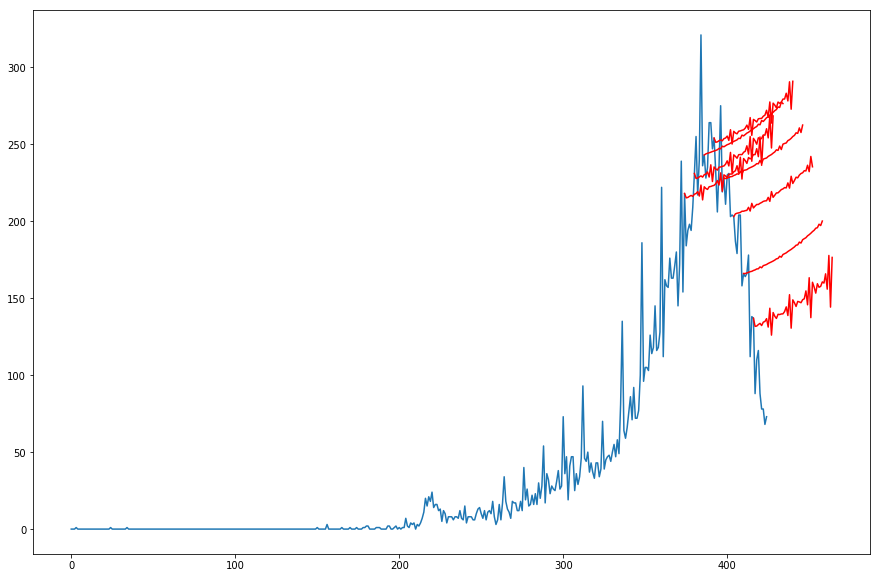

In [119]:
# make forecasts
forecasts = make_forecasts(model, n_batch, train, test, n_lag, n_seq)
# inverse transform forecasts and test
forecasts = inverse_transform(series, forecasts, scaler, n_test+2)
actual = [row[n_lag:] for row in test]
actual = inverse_transform(series, actual, scaler, n_test+2)
# evaluate forecasts
evaluate_forecasts(actual, forecasts, n_lag, n_seq)
# plot forecasts
plot_forecasts(series, forecasts, n_test+2)